### Overview:  Predicting Listing Prices on Airbnb with Spark and Scikit-Learn

One of the most useful things to do with machine learning is inform assumptions about customer behaviors. This has a wide variety of applications: everything from helping customers make superior choices (and often, more profitable ones), making them contagiously happy about your business, and building loyalty over time. Increasingly, it's not enough to simply let your customers pick and choose from the products and services options offered. Customers expect intelligent recommendations and for you to chart courses of action with minimal room for ambiguity or misinterpretation.

Sounds straightforward enough.. how do you actually make it happen? Let's take our own slice of the new "sharing economy" and look at a soup-to-nuts example in Python and the very popular scikit-learn package, using the Inside Airbnb dataset for San Francisco.

We will also use Apache Spark in a slightly different way than usual. Normally, we would use MLlib for machine learning and fire up some estimators on the problem. But what if you're already using scikit-learn (which comes with its own very cool algorithm cheat sheet)? With the new spark-sklearn integration package, we can "turn scikit-learn up to 11" and scale it to many machines and cores than would otherwise be possible, enabling faster tuning and better results.

### Getting Started

We'll start by predicting the listing price we expect the user to enter for a rental, based on the attributes of the listing. Being able to predict the the price has several applications: we might advise the customer on pricing a unit (maybe display a warning if the number chosen is too large or small), assist in how to advertise it, or inform our own analysis of the market for investment decisions.

Each dataset from Inside Airbnb contains several items of interest:

* *listings.csv.gz* - Detailed listings data, including various attributes (features) of each listing such as number of bedrooms, bathrooms, location, etc.
* *calendar.csv.gz* - Information about the availability calendar for each listing
* *reviews.csv.gz* - Individual reviews for listings
* *neighborhoods and GeoJSON files* - Mappings and detailed information for each neighborhood within a city

This example provides a good basis for exploring the capabilities of scikit-learn in Python and how we can use Apache Spark for cross-validation and tuning of hyperparameters. We'll use the linear regression methods from scikit-learn, and then add Spark to improve the results and speed of an exhaustive search with GridSearchCV and an ensemble method (GradientBoostingRegressor).

### Exploring and Cleaning the Data

First, let's load the listings.csv dataset from MapR-FS into a Pandas dataframe. On MapR, this is conveniently and automatically mounted locally over NFS, which makes ingesting data a lot easier. The data consists of approximately 7000 listings with over 90 different columns, describing each listing in detail. Not all of them are useful, so let's start by picking a few that look like obvious candidates for predicting the listing price.


In [7]:
# !pip install matplotlib
# !pip install pandas

In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
from sklearn import linear_model
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV 
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
# LISTINGSFILE = '/mapr/tmclust1/user/mapr/pyspark-learn/airbnb/listings.csv'
LISTINGSFILE = 'http://data.insideairbnb.com/united-states/ca/san-francisco/2015-11-01/data/listings.csv.gz'

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

# read the file into a dataframe
df = pd.read_csv(LISTINGSFILE, usecols=cols, compression='infer')

len(df.index)

7029

The 'neighborhood_cleansed' field contains the neighborhood of the rental, which is one of San Francisco's 40 different distinct neighborhoods. Not all of them are represented in the data equally -- if we look at the distribution below, we can see it follows a curve, with the Mission having the highest number of listings. There are some neighborhoods, near the tail end of the distribution on the left side, that have very few rows and are going to provide less information. Overall, though, we have a good spread of rows across neighborhoods so this field looks like it could be useful.

<AxesSubplot:>

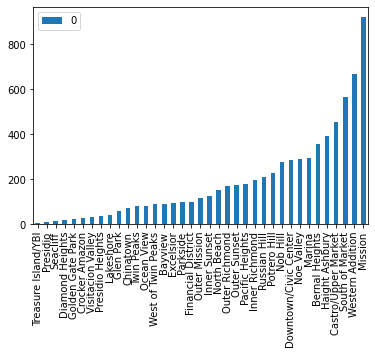

In [13]:
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

This data is coming in a little raw, so some cleaning is in order.

Particularly, the 'number_reviews' and 'reviews_per_month' fields look like they need some special processing to remove a large number of NaN values. Rather than discarding these outright, we set the value of 'reviews_per_month' to 0 where there is currently a NaN, because some quick analysis shows that this field is NaN only wherever 'number_of_reviews' is 0 (which makes some intuitive sense).

We also drop any entries that are obviously strange, such as listings with a value of 0 for bedrooms, beds, or price, then finally drop any remaining rows that have any NaN values. The resulting dataset contains 5246 entries, a subset of the original 7029.

In [14]:
# the number of entries with 0 'number_of_reviews' which do not a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews == 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == False)].index)

0

In [15]:
# the number of entries with at least 1 'number_of_reviews' which have a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

0

In [16]:
# so we need to do some cleaning.

# first fixup 'reviews_per_month' where there are no reviews
df['reviews_per_month'].fillna(0, inplace=True)

# just drop rows with bad/weird values
# (we could do more here)
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

len(df.index)

5246

The last bit of cleaning/filtering we'll do is convert the 'price' column to floating point, and drop all of the entries with more than one bedroom.

Approximately 70% of the entries in this file are for one bedroom listings (in large cities, especially San Francisco, this might be the norm), so it's the type of unit for which we have the most samples. By focusing our regression on a single type of unit, our model will be better as there is less to discover about the complex interactions with other features (such as whether the unit is shared, private, or has a private room). To make predictions for larger units, one way to go would be to develop separate models for each of the different sizes (2, 3, 4 bedrooms, etc.), or do some clustering to see if it is better to partition the data in some other way.

In [17]:
df = df[df.bedrooms == 1]
len(df.index)

3821

In [18]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

0    350.0
2    119.0
5     80.0
7    215.0
9    224.0
Name: price, dtype: float64

We have a few columns that contain categorical variables. These are handled in slightly different ways depending on their possible values.
The 'neighborhood_cleansed' field, in its raw form, is a string representing the name of the neighborhood. The regressors in scikit-learn will only accept numeric fields. For this type of variable we can use the get_dummies routine in Pandas to convert these to 'dummy' variables. This process is also known as "one hot" encoding, meaning we add a column for every possible value of the field. Each listing (row) contains a '1' in for its own neighborhood, else the column contains a '0' for that neighborhood.

We handle this in a similar way for the 'room_type' and 'cancellation_policy' fields.

For the instant_bookable field, we can represent it with a single column since it's a boolean value (it represents whether or not the unit can be booked instantly online without confirmation from the owner).

In [19]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Bayview,Bernal Heights,...,Western Addition,Entire home/apt,Private room,Shared room,flexible,moderate,strict,super_strict_30,super_strict_60,instant_t
0,2,1.0,1.0,350.0,30,8,89.0,0.28,0,0,...,0,1,0,0,0,0,1,0,0,0
2,2,1.0,1.0,119.0,15,10,92.0,2.33,0,0,...,0,0,1,0,0,0,1,0,0,0
5,2,1.0,1.0,80.0,20,24,94.0,1.13,0,0,...,0,0,1,0,0,1,0,0,0,0
7,3,1.0,1.0,215.0,0,1,100.0,0.18,0,0,...,0,1,0,0,0,1,0,0,0,0
9,4,1.0,3.0,224.0,0,57,97.0,3.94,0,0,...,0,1,0,0,0,0,1,0,0,0


Using the ```scatter_matrix``` function in Pandas next, we can quickly show a matrix of each feature as a function of another, checking for any collinearity among the features. The cells along the diagonal of this matrix contain a histogram, with the values shown along the X axis. Collinearity in this case is less likely because we've picked a small set of features that are not obviously related to each other, but it's a good thing to check anyway to see if we have anything that will throw things off.

/Users/huhtis/Dev/2021-03-joda-spark-sklearn-airbnb-predict/VENV/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


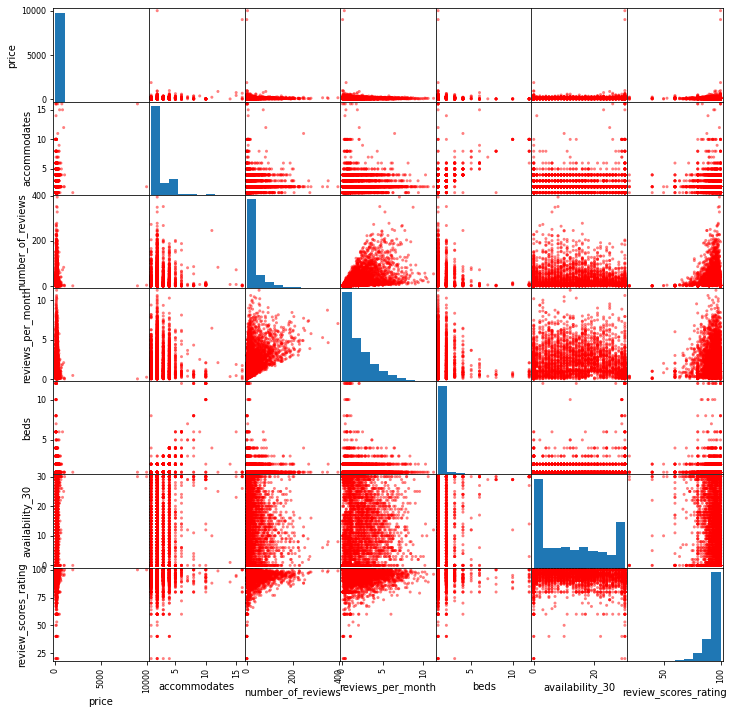

In [21]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.plotting.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

Looking at the output of ```scatter_matrix```, no features show any obvious problems. 
The most closely related features appear to be 'beds' and 'accommodates'.
It's true that the more beds a unit has, the more it accommodates for sleeping,
but even these are only loosely related and the result is far from a straight line.
Presumably this is because of different bed sizes, sleeping arrangements, and
layout of the rental unit.

### Making Predictions with Scikit-Learn and Spark

One of the great things about scikit-learn is that we can easily try a bunch of different linear models on the same data. This will give us some clues as to where we can start tuning. We will start with six of them: vanilla linear regression, ridge and lasso regressions, ElasticNet, bayesian ridge, and a lesser used one called Orthogonal Matching Pursuit.

To evaluate which model(s) are doing better, we will need some way to score the results. In this example I've chosen median absolute error, mainly because it makes sense at a glance (it easily translates to a dollar amount relative to price) and is less sensitive to outliers than other metrics like mean squared error.

Speaking of which, it is fairly likely that we have some outliers in the data since we haven't done any filtering or clustering for them, so this is a good way to get a quick and dirty measure of performance before we move to fine-tuning (and of course, we could do more with outliers in the data preparation step).

Text(0, 0.5, 'Median Absolute Error')

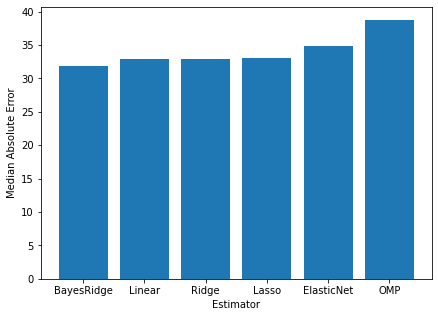

In [22]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Looking at the error from each of these six estimators, they appear to be roughly the same with most of the estimators being able to predict the price with a median error around 30-35 dollars, with BayesRidge coming out on top by a small margin. Having the results be this close isn't surprising, because we haven't done any tuning. The results give us a good general idea of where we stand with the individual estimators.

Next we'll try an ensemble method to see if we can get better results. The upside is that we will likely get a better score, and the downside is that the ensemble methods have a bewildering variety of hyperparameters that must be tuned, each of which can affect our model and requires some experimentation to get right. The common way to approach this is to use an exhaustive "grid search" which simply tries all the supplied parameter combinations and uses cross-validation folding to find the best one. Scikit-learn provides the very handy GridSearchCV function for this purpose.

The tradeoff of using GridSearchCV is that the exhaustive search and cross-validation can take a lot of CPU and time. This is where we can use Spark to distribute the search to more machines and cores, enabling us to test more combinations faster.

For our first attempt, we'll limit the number of parameters just so we can get the results back quickly and see if we're doing better than any of the individual methods above.

In [54]:
# sorted(sklearn.metrics.SCORERS.keys())

In [56]:
n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=4,
                          n_estimators=300)

In [59]:
abs(clf.best_score_)

23.571209743638303

The result of this attempt is a median error of $23.64.

Already, it looks like we're doing better with GradientBoostingRegressor than we were with any of the prior attempts. Without doing any tuning, the median error is around 20% less than the best error of the previous group (with BayesRidge()).

Let's get a quick measure of how the error is affected by each round of boosting, so we can see if throwing more iterations at the problem is going to help.

Text(0, 0.5, 'Least Absolute Deviation')

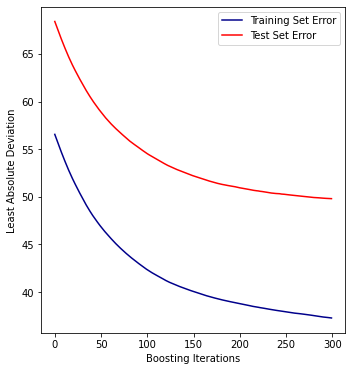

In [60]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

It looks like the curve is flattening near the right side of the plot (after around 200-250 iterations), but is still benefitting from more iterations, so we could increase the iterations to 500 without much thought.

Now we can do some tuning with GridSearchCV and explore more of the hyperparameter combinations. However, this requires some serious CPU and a complete run of all of the combinations can easily take hours to finish, even on a small number of rows.

By simply replacing the following lines in our file, we can use the new spark-sklearn integration package running on the [MapR 5.1 platform with Spark as a YARN client](http://maprdocs.mapr.com/51/index.html#Spark/SparkonYARN.html) to distribute the iterations across the machines in a cluster. This allows us to test more hyperparameter combinations, ultimately reducing error, and we can do it all in less time.

```
from pyspark import SparkContext, SparkConf
from spark_sklearn import GridSearchCV

conf = SparkConf()
sc = SparkContext(conf=conf)
clf = GridSearchCV(sc, gbr, cv=3, param_grid=tuned_parameters, scoring='median_absolute_error')
```

You can then run the script in this notebook with the following command, setting --num-executors and --executor-cores to suit your Spark environment:

```
time MASTER=yarn-client /opt/mapr/spark/spark-1.5.2/bin/spark-submit --num-executors=2 --executor-cores=8 python_scikit_airbnb.py
```

It's worth pausing here to note that the architecture of this approach is different than that used by MLlib in Spark. Using spark-sklearn, we're simply distributing the cross-validation run of each model (with a specific combination of hyperparameters) across each Spark executor. Spark MLlib, on the other hand, will distribute the internals of the actual learning algorithms across the cluster.
The main advantage of spark-sklearn is that it enables leveraging the very rich set of machine learning algorithms in scikit-learn. These algorithms do not run natively on a cluster (although they can be parallelized on a single machine) and by adding Spark, we can unlock a lot more horsepower than could ordinarily be used.

**Using this approach we can get the error down even further, to $21.43**, with a substantial reduction in time.

Finally let's look at the feature importances to see which features were most influential in predicting the listing price. This will show us a relative scoring of how important each feature is relative to the feature with the most importance.

Text(0.5, 1.0, 'Variable Importance')

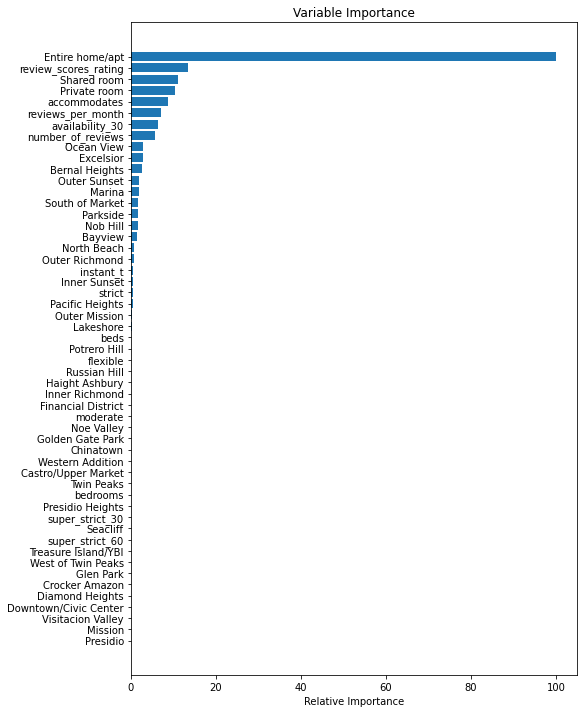

In [38]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Clearly some of the variables have more influence than others, and the results here are somewhat intuitive. The most influential feature is the 'Entire home/apt' attribute; this indicates whether or not the unit is shared with other people, and has the most effect in setting the price. We would probably expect this feature to be high on the list, and it might be even higher o Reviews are important, as is the short-term availability of the unit, and the Ocean View and Excelsior neighborhood features also scored high.

### Conclusions

In this example we looked at how to predict the price using multiple factors, then scale-out our cross validation and hyperparameter search across a MapR cluster using Spark. We learned the following key points:

* In this case, the ensemble method we tried (GradientBoostingRegressor) had better results than any individual estimator.

* With GridSearchCV, we tested more hyperparameter combinations that ultimately led us to a better result.

* Using [spark-sklearn](https://github.com/databricks/spark-sklearn) is a straightforward way to throw more CPU at any machine learning problem you might have.  We used the package to reduce the time spent searching and reduce the error for our estimator.

There are many ways in which our first-pass analysis could be improved.  For example, we might start including more of the data from Inside Airbnb.  We could do sentiment analysis on the text of the reviews, bringing this in as an additional feature.

A quick way to try the example code here on your own is with the [MapR Sandbox](https://www.mapr.com/products/mapr-sandbox-hadoop/tutorials/spark-tutorial), which comes pre-installed with MapR-FS and Spark.

In the next post in the series we'll look at how to to apply the same technique to building a classifier.
